# Accessing, QCing, and Binning Nitrate and CTD Data from OOI Profilers

This notebook is a companion to the Data in Brief article and goes through each step used to access, quality control, and bin nitrate data from Endurance Array profilers. In order for this notebook to run correctly, make sure you have cloned the [full repository](https://github.com/andrew-s28/ooi-profiler-nitrate-retriever) and activated the correct conda environment. 

These are the imports and all of the functions wew will need in the QC and binning process.

In [1]:
# Python Standard Library
from datetime import datetime
import io
import re
import warnings

# External Modules
from bs4 import BeautifulSoup
from flox.xarray import xarray_reduce
import gsw
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm as tq
import xarray as xr


def _filter_dates(nc_files: list, start_date: str, end_date: str) -> list:
    # filter the list of files by the start and end dates provided
    date_regex = r'[0-9]+T[0-9]+\.[0-9]+-[0-9]+T[0-9]+\.[0-9]+'
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    # get start and end dates of each deployment from the file names
    nc_files_start_dates = [datetime.strptime(re.search(date_regex, f).group(0).split('-')[0], '%Y%m%dT%H%M%S.%f') for f in nc_files]
    nc_files_end_dates = [datetime.strptime(re.search(date_regex, f).group(0).split('-')[1], '%Y%m%dT%H%M%S.%f') for f in nc_files]
    # filter by start date, including any data files that end after the start date
    nc_files = [f for i, f in enumerate(nc_files) if nc_files_end_dates[i] >= start_date]
    # filter by end date, including any data files that start before the end date
    nc_files = [f for i, f in enumerate(nc_files) if nc_files_start_dates[i] <= end_date]
    return nc_files


def _get_attrs(ds) -> tuple[dict, dict]:
    # get and store the global and variable attributes for the dataset
    global_attrs = ds.attrs
    var_attrs = {}
    for var in list(ds.variables):
        var_attrs.update({var: ds[var].attrs})
    return global_attrs, var_attrs


def _assign_attrs(ds: xr.Dataset, global_attrs: dict, var_attrs: dict) -> xr.Dataset:
    # assign the global and variable attributes to the dataset
    ds.attrs = global_attrs
    for var in list(ds.variables):
        ds[var].attrs = var_attrs[var]
    return ds


def list_files(url: str, start_date: str, end_date: str, tag=r'.*\.nc$') -> list[str]:
    """
    Function to create a list of the netCDF data files in the THREDDS catalog
    created by a request to the M2M system. Obtained from 2022 OOIFB workshop

    Args:
        url (str): URL to a THREDDS catalog specific to a data request
        tag (regexp, optional): Regex pattern used to distinguish files of interest. Defaults to r'.*\\.nc$'.

    Returns:
        array: list of files in the catalog with the URL path set relative to the catalog
    """
    with requests.session() as s:
        page = s.get(url).text

    soup = BeautifulSoup(page, 'html.parser')
    pattern = re.compile(tag)
    nc_files = [node.get('href') for node in soup.find_all('a', string=pattern)]
    nc_files = [re.sub('catalog.html\\?dataset=', '', file) for file in nc_files]
    nc_files = _filter_dates(nc_files, start_date, end_date)
    return nc_files


def _drop_unused_vars(ds: xr.Dataset) -> xr.Dataset:
    ds = ds.drop_vars([
        'nutnr_nitrogen_in_nitrate_qc_executed',
        'nutnr_spectrum_average',
        'nutnr_fit_base_2',
        'nutnr_fit_base_1',
        'year',
        'salinity_corrected_nitrate_qartod_results',
        'salinity_corrected_nitrate_qc_results',
        'sea_water_pressure_qc_executed',
        'nutnr_current_main',
        'sea_water_practical_salinity_qc_executed',
        'nitrate_concentration_qc_results',
        'humidity',
        'voltage_main',
        'sea_water_pressure_qc_results',
        'spectral_channels',
        'temp_spectrometer',
        'temp_lamp',
        'day_of_year',
        'nutnr_nitrogen_in_nitrate',
        'nitrate_concentration',
        'nutnr_absorbance_at_254_nm',
        'nutnr_absorbance_at_350_nm',
        'temp_interior',
        'nutnr_bromide_trace',
        'sea_water_temperature_qc_results',
        'nutnr_integration_time_factor',
        'lamp_time',
        'nitrate_concentration_qc_executed',
        'time_of_sample',
        'nutnr_nitrogen_in_nitrate_qc_results',
        'nitrate_concentration_qartod_results',
        'sea_water_practical_salinity_qc_results',
        'sea_water_temperature_qc_executed',
        'nutnr_voltage_int',
        'salinity_corrected_nitrate_qc_executed',
        'suspect_timestamp',
        'aux_fitting_1',
        'nutnr_fit_rmse',
        'dark_val',
        'aux_fitting_2',
        'voltage_lamp',
    ]).drop(
        'wavelength'
    )
    return ds


def _comput_tsrho(ds: xr.Dataset) -> xr.Dataset:
    # renames and computes variables
    ds = ds.swap_dims({'obs': 'time'})
    # sea_water_temperature and sea_water_practical_salinity have junk values
    ds = ds.drop_vars(['sea_water_temperature', 'sea_water_practical_salinity', 'sea_water_pressure'])
    ds = ds.rename({
        'ctdpf_j_cspp_instrument_recovered-sea_water_temperature': 'temperature',
        'ctdpf_j_cspp_instrument_recovered-sea_water_practical_salinity': 'practical_salinity',
        'nutnr_dark_value_used_for_fit': 'dark_val',
        'int_ctd_pressure': 'pressure',
        })
    ds['absolute_salinity'] = gsw.conversions.SA_from_SP(
        SP=ds['practical_salinity'],
        p=ds['pressure'],
        lon=ds['lon'],
        lat=ds['lat']
    )
    ds['absolute_salinity'].attrs = {
        'long_name': 'Seawater Absolute Salinity',
        'standard_name': 'sea_water_absolute_salinity',
        'units': 'g/kg'
    }
    ds['conservative_temperature'] = gsw.conversions.CT_from_t(
        SA=ds['absolute_salinity'],
        t=ds['temperature'],
        p=ds['pressure']
    )
    ds['conservative_temperature'].attrs = {
        'long_name': 'Seawater Conservative Temperature',
        'standard_name': 'sea_water_conservative_temperature',
        'units': 'degrees_Celsius',
        'units_metadata': 'temperature: on_scale'
    }
    ds['sigma_t'] = gsw.density.rho(
        SA=ds['absolute_salinity'],
        CT=ds['conservative_temperature'],
        p=ds['pressure']
    ) - 1000
    ds['sigma_t'].attrs = {
        'long_name': 'Seawater Density Anomaly',
        'standard_name': 'sea_water_sigma_t',
        'units': 'kg/m^3',
    }
    ds['sigma_theta'] = gsw.density.sigma0(
        SA=ds['absolute_salinity'],
        CT=ds['conservative_temperature']
    )
    ds['sigma_theta'].attrs = {
        'long_name': 'Seawater Potential Density Anomaly',
        'standard_name': 'sea_water_sigma_theta',
        'units': 'kg/m^3',
        'reference_pressure': 0
    }
    return ds


def _plot_qc(fig, ax, title, ds: xr.Dataset, mask: np.ndarray, already_masked: int = 0) -> None:
    # plots the QC steps for the nitrate data
    inital_length = ds.time.values.size
    ds_masked = ds.where(xr.DataArray(mask, coords={'time': ds.time.values}), drop=True)
    masked_this_step = inital_length - ds_masked.time.values.size - already_masked
    ax.plot(ds_masked.time, ds_masked.salinity_corrected_nitrate, c='#004488', label=f'Good datapoints: {ds_masked.time.values.size}\nRemoved datapoints: {masked_this_step}')
    ax.set_title(title)
    ax.legend(loc='upper right', facecolor='w', edgecolor='k', framealpha=1)


def _nutnr_qc(
    spectral_channels: np.ndarray,
    dark_val: np.ndarray,
    salinity: np.ndarray,
    time: np.ndarray,
    rmse_lim: float,
    ds: xr.Dataset = None,
    site: str = None,
) -> tuple[np.ndarray, np.ndarray, int, int, int, int, int, int]:
    # does the actual QC as vectorized numpy operations
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="Mean of empty slice")
        warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
        warnings.filterwarnings("ignore", message="invalid value encountered in log10")
        warnings.filterwarnings("ignore", message="divide by zero encountered in log10")
        
        wavelengths = np.arange(190, 394.01, .8)[30:]
        spectral_channels = (spectral_channels.T - dark_val).T[:, 30:]
        mask = np.full(time.shape, True, dtype=bool)
        a_all = np.empty(len(time))
        a_all[:] = np.nan
        step_1, step_2, step_3, step_4 = 0, 0, 0, 0
        
        if ds is None:
            # mask observations with low salinity values
            mask[(salinity <= 28) & (mask)] = False
            step_1 = np.count_nonzero(~mask)

            # mask spectra with non-finite or negative values
            mask[(np.any(~np.isfinite(spectral_channels), axis=1)) & (mask)] = False
            mask[(np.any(spectral_channels <= 0, axis=1)) & (mask)] = False
            step_2 = np.count_nonzero(~mask) - step_1

            # fit spectra to linear model between wavelengths ~360 nm to 380 nm and remove bad fits 
            wl_fit = wavelengths[217-30:241-30]
            spec_fit = np.log10(spectral_channels[:, 217-30:241-30])
            rmse_all = np.empty(len(spec_fit))
            rmse_all[:] = np.nan
            for i, sp in enumerate(spec_fit):
                if np.any(~np.isfinite(sp)):
                    if mask[i]:
                        print("Why is this happening? This shouldn't be happening.") # any non-finite values should have been removed in step 2
                        mask[i] = False
                        step_2 += 1
                else:
                    a, ssres, _, _ = np.linalg.lstsq(np.vstack([np.ones(wl_fit.shape), wl_fit]).T, sp, rcond=None)
                    residuals = sp - wl_fit*a[1] - a[0]
                    rmse = np.sqrt(np.sum(residuals**2)/(residuals.size-2))
                    rmse_all[i] = rmse
                    if rmse > rmse_lim:
                        if mask[i]:
                            mask[i] = False
                            step_3 += 1
                    else:
                        a_all[i] = a[1]

            # remove spectra with slope far from the mean slope
            a_all[~mask] = np.nan
            mask[(np.abs(a_all - np.nanmean(a_all)) >= 3*np.nanstd(a_all)) & (mask)] = False
            step_4 = np.count_nonzero(~mask) - step_1 - step_2 - step_3
        else:
            fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
            _plot_qc(fig, axs[0], 'Original Data', ds, mask)
            
            # mask observations with low salinity values
            mask[(salinity <= 28) & (mask)] = False
            step_1 = np.count_nonzero(~mask)
            _plot_qc(fig, axs[1], 'Step 1: Removed Low Salinity Values', ds, mask)

            # mask spectra with non-finite or negative values
            mask[(np.any(~np.isfinite(spectral_channels), axis=1)) & (mask)] = False
            mask[(np.any(spectral_channels <= 0, axis=1)) & (mask)] = False
            step_2 = np.count_nonzero(~mask) - step_1
            _plot_qc(fig, axs[2], 'Step 2: Removed Spectra with NaN or Negative Values', ds, mask, step_1)

            # # mask spectra with low mean values
            # mask[(np.nanmean(spectral_channels, axis=1) < 3) & (mask)] = False
            # step_3 = np.count_nonzero(~mask) - step_1 - step_2

            # fit spectra to linear model between wavelengths ~360 nm to 380 nm and remove bad fits 
            wl_fit = wavelengths[217-30:241-30]
            spec_fit = np.log10(spectral_channels[:, 217-30:241-30])
            rmse_all = np.empty(len(spec_fit))
            rmse_all[:] = np.nan
            for i, sp in enumerate(spec_fit):
                if np.any(~np.isfinite(sp)):
                    if mask[i]:
                        print("Why is this happening? This shouldn't be happening.")
                        mask[i] = False
                        step_2 += 1
                else:
                    a, ssres, _, _ = np.linalg.lstsq(np.vstack([np.ones(wl_fit.shape), wl_fit]).T, sp, rcond=None)
                    residuals = sp - wl_fit*a[1] - a[0]
                    rmse = np.sqrt(np.sum(residuals**2)/(residuals.size-2))
                    rmse_all[i] = rmse
                    if rmse > rmse_lim:
                        if mask[i]:
                            mask[i] = False
                            step_3 += 1
                    else:
                        a_all[i] = a[1]
            _plot_qc(fig, axs[3], 'Step 3: Removed Spectra with Bad Linear Fits', ds, mask, step_1 + step_2)

            # remove spectra with slope far from the mean slope
            a_all[~mask] = np.nan
            mask[(np.abs(a_all - np.nanmean(a_all)) >= 3*np.nanstd(a_all)) & (mask)] = False
            step_4 = np.count_nonzero(~mask) - step_1 - step_2 - step_3
            _plot_qc(fig, axs[4], 'Step 4: Removed Fits with Slopes Far From the Mean', ds, mask, step_1 + step_2 + step_3)
            fig.supylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)', x=0.05)
            # fig.suptitle(f'QC for Deployment {ds.deployment.values[0]} at site {site}', y=0.93)
        return mask, a_all, step_1, step_2, step_3, step_4


def _nutnr_qc_wrapper(ds: xr.Dataset, rmse_lim: float = 0.02, plot_deployments: list = [17, 18], site: str = None) -> xr.Dataset:
    # provide numpy arrays to apply QC, and separate some deployments for plotting just for this notebook
    if ds.deployment.values[0] in plot_deployments:
        mask, a_all, step_1, step_2, step_3, step_4 = _nutnr_qc(
            ds.spectral_channels.values,
            ds.dark_val.values,
            ds.practical_salinity.values,
            ds.time.values,
            rmse_lim=rmse_lim,
            ds=ds,
            site=site,
        )
    else:
        mask, a_all, step_1, step_2, step_3, step_4 = _nutnr_qc(
            ds.spectral_channels.values,
            ds.dark_val.values,
            ds.practical_salinity.values,
            ds.time.values,
            rmse_lim=rmse_lim,
        )
    # mask the data
    ds = ds.where(xr.DataArray(mask, coords={'time': ds.time.values}), drop=True)
    return ds, len(ds.time.values), step_1, step_2, step_3, step_4


def split_profiles(ds: xr.Dataset) -> list:
    """
    Split the data set into individual profiles, where each profile is a
    collection of data from a single deployment and profile sequence. The
    resulting data sets are returned in a list.

    :param ds: data set containing the profile data
    :return: a list of data sets, one for each profile
    """
    # split the data into profiles, assuming at least 120 seconds between profiles
    dt = ds.where(ds['time'].diff('time') > np.timedelta64(120, 's'), drop=True).get_index('time')

    # process each profile, adding the results to a list of profiles
    profiles = []
    jback = np.timedelta64(30, 's')  # 30 second jump back to avoid collecting data from the following profile
    for i, d in enumerate(dt):
        # print(d)
        # pull out the profile
        if i == 0:
            profile = ds.sel(time=slice(ds['time'].values[0], d - jback))
        else:
            profile = ds.sel(time=slice(dt[i - 1], d - jback))

        # add the profile to the list
        profiles.append(profile)

    # grab the last profile and append it to the list
    profile = ds.sel(time=slice(d, ds['time'].values[-1]))
    profiles.append(profile)
    return profiles


def profiler_binning(d, z, z_lab='depth', t_lab='time', offset=0.5) -> xr.DataArray | xr.Dataset:
    """
    Bins a profiler time series into daily bins and depth bins.
    Removes any non-numeric data types, including any time types,
    outside of the coordinates.

    input:
    d = xr.Dataset with coordinates depth and time
    z = depth bins array
    z_lab, t_lab = labels for depth, time in d

    returns:
    Binned xr.Dataset
    Args:
        d (xr.dataset): OOI profiler dataset
        z (array): edges of depth/pressure bins
        z_lab (str, optional): name of depth/pressure in dataset. Defaults to 'depth'.
        t_lab (str, optional): name of time in dataset. Defaults to 'time'.
        offset (float, optional): Distance from location to CTD (positive when CTD is higher).
            Defaults to 0.5.

    Returns:
        xr.dataset: binned dataset
    """
    types = [d[i].dtype for i in d]
    vars = list(d.keys())
    exclude = []
    for i, t in enumerate(types):
        if not (np.issubdtype(t, np.number)):
            exclude.append(vars[i])
    d = d.drop_vars(exclude)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        out = xarray_reduce(
            d,
            d[t_lab],
            d[z_lab],
            func='nanmean',
            expected_groups=(None, z),
            isbin=[False, True],
            method='map-reduce',
            skipna=True,
        )

    depth = np.array([x.mid + offset for x in out.depth_bins.values])
    out[z_lab] = ([z_lab + '_bins'], depth)
    out = out.swap_dims({z_lab + '_bins': z_lab})
    out = out.drop_vars([z_lab + '_bins'])

    return out


def _get_datasets(site: str, start_date: str, end_date: str) -> list:
    if site == 'CE01ISSP':
        # setup defaults to use in subsequent data queries
        refdes = site + "-SP001-06-NUTNRJ000"
        method = "recovered_cspp"
        stream = "nutnr_j_cspp_instrument_recovered"
    elif site == 'CE02SHSP':
        refdes = site + "-SP001-05-NUTNRJ000"
        method = "recovered_cspp"
        stream = "nutnr_j_cspp_instrument_recovered"
    else:
        raise ValueError("Invalid site selection, choose one or more of CE01ISSP (Oregon inshore) or CE02SHSP (Oregon midshelf).")

    # construct the OOI Gold Copy THREDDS catalog URL for this data set
    base_url = "https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/"
    url = base_url + ('-').join([refdes, method, stream]) + '/catalog.html'
    tag = r'NUTNRJ000.*.nc$'  # setup regex for files we want
    nc_files = list_files(url, start_date, end_date, tag)
    base_url = 'https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/'
    nc_url = [base_url + i + '#mode=bytes' for i in nc_files]  # create urls for download
    # nc_url = nc_url[:5]
    # load datasets
    ds = []
    for i, f in (enumerate(tq(nc_url, desc='Downloading datasets'))):
        r = requests.get(f, timeout=(3.05, 120))
        if r.ok:
            ds.append(xr.open_dataset(io.BytesIO(r.content)))
            ds[i].load()
    return ds

## Site CE01ISSP

### Accessing the Dataset

First, we obtain all of the datasets for the site using `_get_datasets()` and save them to the list `ds`.

In [2]:
# download all datasets
ds = _get_datasets('CE01ISSP', '2010-01-01', pd.Timestamp.now().strftime('%Y-%m-%d'))
# save original data for comparison
ds_orig = ds.copy()

Next we do some variable renaming and calculate the absolute salinity, conservative temperature, and potential density. We also save the metadata to include with the final dataset, since the next steps will remove it.

In [3]:
for i, d in enumerate(ds):
    # compute derived variables
    ds[i] = _comput_tsrho(d)
    # save metadata to include in final dataset
    global_attrs, var_attrs = _get_attrs(ds[i])

### Performing Quality Control

Now for the most important part. We quality control the nitrate data according to the algorithm:
1)	If the practical salinity is less than 28 PSU, remove this datapoint. The nitrate salinity and temperature correction algorithm was not tested at these lower values, so accuracy cannot be assured [7].
2)	If there are any “not a number” (nan) or negative values in the spectra, remove this datapoint. This means the instrument had malfunctioned in some way or that the optical path was severely impacted (e.g., by dense particulate matter).
3)	Fit the spectra between a wavelength of 360 nm and 380 nm with a linear least squares regression. These wavelengths are far from the peak absorption spectra of nitrate or seawater [7]. Over this wavelength range, the major absorber is expected to be chromophoric dissolved organic matter (CDOM). CDOM should have an absorption spectrum that is approximately linear over small wavelength ranges [9]. Thus, we remove any fits that deviate from linearity with a root mean square error greater than 0.02 or that fail to converge. A linear dependence on wavelength is explicitly accounted for in the salinity and temperature correction algorithm [7], but if the background spectrum is not approximately linear, then this algorithm is not valid and the accuracy of the measurement is suspect.
4)	Finally, the mean and standard deviation of the slope of the linear fits from the previous step are calculated for all the "good" data as determined by steps 1-4. Any fit with a slope more than five standard deviations away from the mean is removed. A strong deviation from the mean is indicative of an unknown absorber present in the optical path, which makes the accuracy of the measurement suspect.

The amount of removed points in each step are recorded to be saved to a report. However, we will skip this portion for the purposes of this example and just show what the QC process looks like applied to deployments 17 and 18.

QCing datasets: 100%|██████████| 21/21 [00:06<00:00,  3.33it/s]


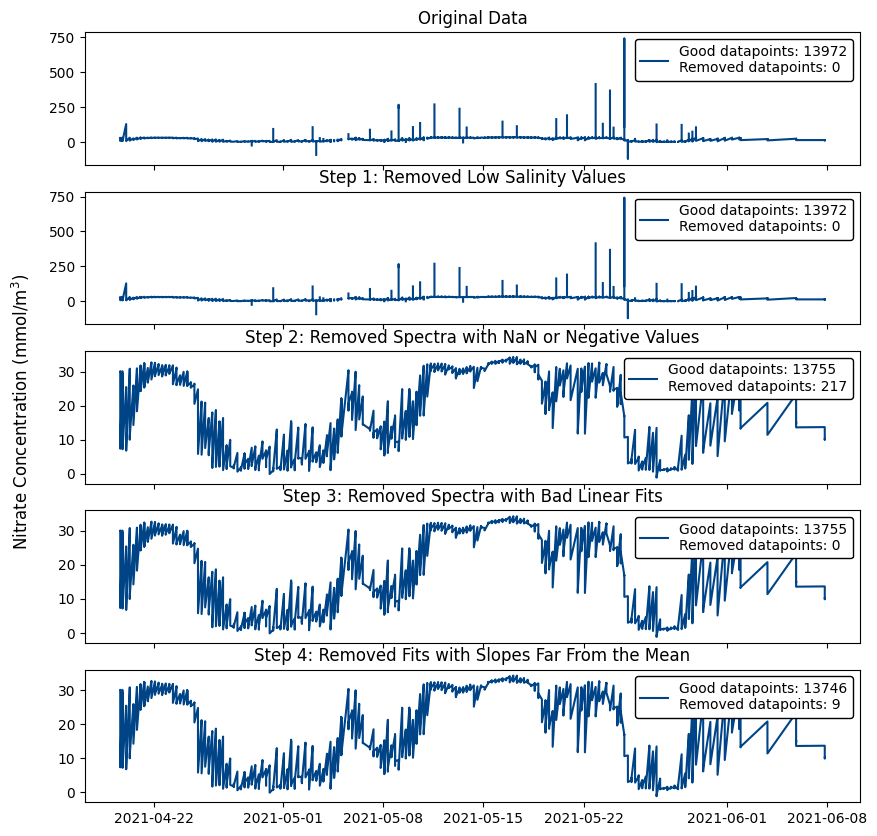

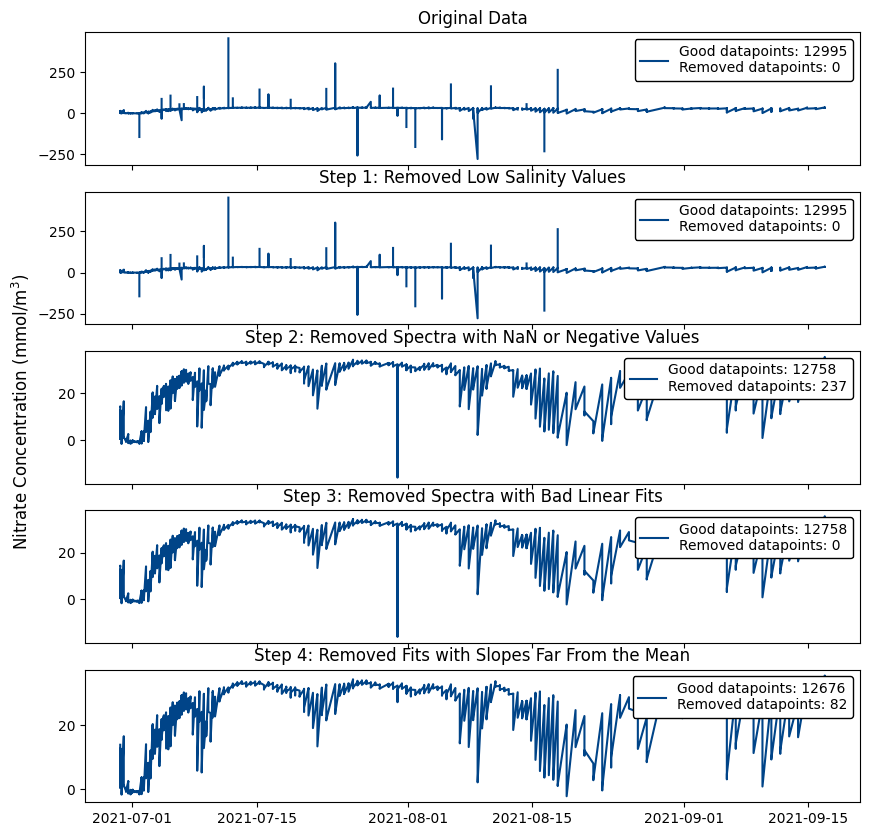

In [4]:
# QC nitrate data and remove short datasets
deployments, total_data, good_data, step_1, step_2, step_3, step_4 = [], [], [], [], [], [], []
for i, d in enumerate(tq(ds, desc='QCing datasets')):
    deployments.append(np.unique(d.deployment)[0])
    total_data.append(d.time.size)  
    out = _nutnr_qc_wrapper(d, site='CE01ISSP')
    if deployments[-1] in [17, 18]:
        plt.savefig(f'./CE01ISSP_dep{deployments[-1]}_qc.png', dpi=600)
    ds[i] = out[0]
    good_data.append(out[1])
    step_1.append(out[2])
    step_2.append(out[3])
    step_3.append(out[4])
    step_4.append(out[5])

# save QC results to DataFrame
qc_results = pd.DataFrame(
    {
        'deployment': deployments,
        'total_data': total_data,
        'good_data': good_data,
        'bad_data': np.subtract(np.array(total_data), np.array(good_data)),
        'bad_salinity': step_1,
        'bad_values': step_2,
        'bad_fit': step_3,
        'bad_slope': step_4,
    },
    columns=['deployment', 'total_data', 'good_data', 'bad_data', 'bad_salinity', 'bad_values', 'bad_fit', 'bad_slope'],
)

We can see the majority of really bad data is removed simply by removing spectra that contain NaN or negative values (step 2). The other steps just handle a few stray outliers. Now that the QC process is done (and notice that we have already saved the output to the same variable `ds`), we can proceed to the binning and saving. First, we remove datasets which have no data after the QC process. We also save the unbinned but QCed dataset for later use.

In [5]:
# remove datasets with no data after QC
for i, d in enumerate(ds):
    if d.time.size == 0:
        ds.pop(i)
        print(f"Deployment {ds_orig[i].deployment.values[0]} removed due to lack of data after QC.")
ds_qced = ds.copy()

### Binning

Now we get the highest and lowest depth bins from the entire dataset and construct some bin centers and edges using a 1 m bin height.

In [6]:
# find minimum and maximum depth bins over all nitrate data
sur = np.min(xr.concat(ds, dim='time')['depth'])
bot = np.max(xr.concat(ds, dim='time')['depth'])

# setup depth/pressure bins
step = 1
sur = np.floor(sur)
bot = np.ceil(bot)
# pressure_grid is centers of bins
pressure_grid = np.arange(sur+step/2, bot+step, step)
# pressure_bins is edges of bins
pressure_bins = np.nan*np.empty(len(pressure_grid)+1)
pressure_bins[0] = pressure_grid[0] - step/2
pressure_bins[-1] = pressure_grid[-1] + step/2
for i in range(len(pressure_bins)-2):
    pressure_bins[i+1] = np.average([pressure_grid[i], pressure_grid[i+1]])

Finally, we bin them using an optimized binning algorithm, `flox.xarray_reduce`. This significantly speeds up the binning operation, but it still takes a few minutes. Run this next cell and go grab yourself some coffee while you wait!

In [7]:
# bin datasets into new list
deployments = []
times = []
for d in tq(ds, desc='Splitting and binning profiles'):
    deployments.append(split_profiles(d))
    # print(deployments[-1])
    profiles = []
    profile_times = []
    for profile in deployments[-1]:
        profile_binned = profiler_binning(profile, pressure_bins, offset=0.5)
        profiles.append(profile_binned.mean(dim='time'))
        profile_times.append(profile_binned.time.mean().values)
    deployments[-1] = profiles
    times.append(xr.DataArray(profile_times, dims='time'))
deployments = [xr.concat(profiles, profile_times) for profiles, profile_times in zip(deployments, times)]
# remove datasets with less than 10 profiles data
for i, d in enumerate(deployments):
    if d.time.size < 10:
        deployments.pop(i)
        print(f"Deployment {d.deployment.mean().values} removed due to having less than 10 profiles after QC and binning.")

# concatenate binned datasets
ds_bin = xr.concat(deployments, dim='time')
ds_bin = ds_bin.drop_duplicates('time', keep='first')
ds_bin = ds_bin.where(~np.isinf(ds_bin.salinity_corrected_nitrate))
ds_bin = _assign_attrs(ds_bin, global_attrs, var_attrs)

Splitting and binning profiles: 100%|██████████| 21/21 [02:02<00:00,  5.84s/it]


Deployment 11.0 removed due to having less than 10 profiles after QC and binning.
Deployment 16.0 removed due to having less than 10 profiles after QC and binning.


### Reviewing the Results

Before we go any further, let's take a look at the QC results.

In [8]:
qc_results

,deployment,total_data,good_data,bad_data,bad_salinity,bad_values,bad_fit,bad_slope
0,1,1136,1123,13,7,2,0,4
1,2,256,255,1,0,1,0,0
2,3,875,868,7,0,4,0,3
3,4,1129,1116,13,0,4,0,9
4,5,1703,1617,86,7,62,0,17
5,6,1484,1471,13,1,11,0,1
6,7,2736,2598,138,0,131,1,6
7,8,1888,1802,86,1,72,0,13
8,9,305,303,2,0,0,0,2
9,10,1055,990,65,0,59,0,6


They look pretty good, with a few percent of data being thrown out from each deployment. However, one major exception exists, which is Deployment 20 (row 18), where 5,648 out of 9,509 datapoints (~60%) were removed in the QC process. This makes the entire deployment suspect, and we remove it just to be on the safe side.

In [9]:
ds_bin = ds_bin.where(ds_bin.deployment != 20, drop=True)

Recalling that deployments 11, 16, and 20 were removed due to having too little data after the QC and binning, the remaining QC results are found by summing the columns.

In [10]:
qc_results[(qc_results.deployment != 11) & (qc_results.deployment != 16) & (qc_results.deployment != 20)].sum(axis=0)

deployment         194
total_data      108553
good_data       105753
bad_data          2800
bad_salinity        42
bad_values        2027
bad_fit              1
bad_slope          730
dtype: int64

We can now get rid of the unused variables in the dataset.

In [11]:
ds_bin = _drop_unused_vars(ds_bin)

### Validating with Bottle Samples

Now we can load up some ship data to compare the optical measurements with. While few of the bottle samples overlap, we can align them in the density-nitrate space. 

Text(0.95, 0.05, '(a)')

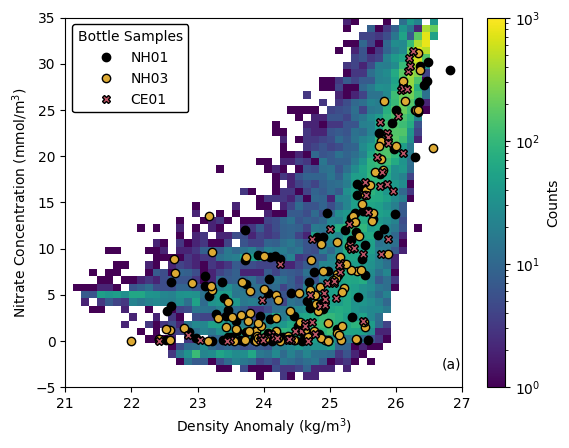

In [13]:
nh01_bottles = xr.open_dataset('bottle_samples/nh01_nitrate_bottles.nc')
nh03_bottles = xr.open_dataset('bottle_samples/nh03_nitrate_bottles.nc')
ce01_bottles = xr.open_dataset('bottle_samples/ce01_nitrate_bottles.nc')

# plot the nitrate data
sigma_theta = ds_bin.sigma_theta.values.flatten()
nitrate = ds_bin.salinity_corrected_nitrate.values.flatten()
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 35, 51)
mask = ((~np.isnan(sigma_theta)) & (~np.isnan(nitrate)))
hist, _, _ = np.histogram2d(sigma_theta[mask], nitrate[mask], bins=[x_bins, y_bins])
hist[hist == 0] = np.nan
pcm = plt.pcolormesh(x_bins, y_bins, hist.T, cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=1000))
plt.colorbar(pcm, label='Counts')
# plt.axhline(-3, c='k', lw=2)

# plot bottle sample data
sigma_theta = nh01_bottles.sigma_theta.values.flatten()
nitrate = nh01_bottles.nitrate.values.flatten()
plt.plot(sigma_theta, nitrate, 'o', label='NH01', mfc='k', mec='k')
sigma_theta = nh03_bottles.sigma_theta.values.flatten()
nitrate = nh03_bottles.nitrate.values.flatten()
plt.plot(sigma_theta, nitrate, 'o', label='NH03', mfc='#DDAA33', mec='k')
sigma_theta = ce01_bottles.sigma_theta.values.flatten()
nitrate = ce01_bottles.nitrate.values.flatten()
plt.plot(sigma_theta, nitrate, 'X', label='CE01', mfc='#BB5566', mec='k')
plt.legend(loc='upper left', title='Bottle Samples', facecolor='w', edgecolor='k', framealpha=1)
plt.xlabel('Density Anomaly ($\mathsf{kg/m^3}$)')
plt.ylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)')
plt.annotate('(a)', xy=(0.95, 0.05), xycoords='axes fraction')

There seems to be a bit of misalignment between some of the deployments and the bottle samples (e.g., notice the elevated tail of low density water with 5 mmol/m^3 nitrate concentration). The nitrate concentration from each deployment has been manually offset with a baseline shift to bring the deployment in line with the bottle sample nitrate data. Most of these shifts are no larger than $\pm$ 4, but note that deployment 1 and 6 both required large offsets. Removing these datasets entirely is not without merit, but I leave that choice up to the user. If one wanted to remove them, it would be as easy as:
```
ds_bin = ds_bin.where(ds_bin.deployment != 1, drop=True)
```
In any case, we proceed with the baseline shifts.

In [14]:
# custom baseline subtractions for deployments at inshore, based on nitrate-density relationship and some overlapping bottle samples
for i, dep in enumerate(deployments):
    d = np.unique(dep.deployment)[0]
    if d == 1:
        baseline = 10
    if d == 2:
        baseline = -4
    elif d == 5:
        baseline = 2
    elif d == 6:
        baseline = 12
    elif d == 7:
        baseline = 1
    elif d == 8:
        baseline = 3
    elif d == 10:
        baseline = -2
    elif d == 14:
        baseline = 0
    elif d == 13:
        baseline = -2
    elif d == 15:
        baseline = 2
    elif d == 16:
        baseline = 2
    elif d == 17:
        baseline = 3
    elif d == 19:
        baseline = 5
    elif d == 21:
        baseline = 1
    else:
        baseline = 0
    deployments[i]['salinity_corrected_nitrate'] = dep['salinity_corrected_nitrate'] - baseline

ds_bin_baseline_subtracted = xr.concat(deployments, dim='time')
ds_bin_baseline_subtracted = _assign_attrs(ds_bin_baseline_subtracted, global_attrs, var_attrs)
ds_bin_baseline_subtracted = _drop_unused_vars(ds_bin_baseline_subtracted)
ds_bin_baseline_subtracted = ds_bin_baseline_subtracted.where(ds_bin_baseline_subtracted.deployment != 20, drop=True)

### Wrapping Up

Taking a look at the nitrate-density graph one more time:

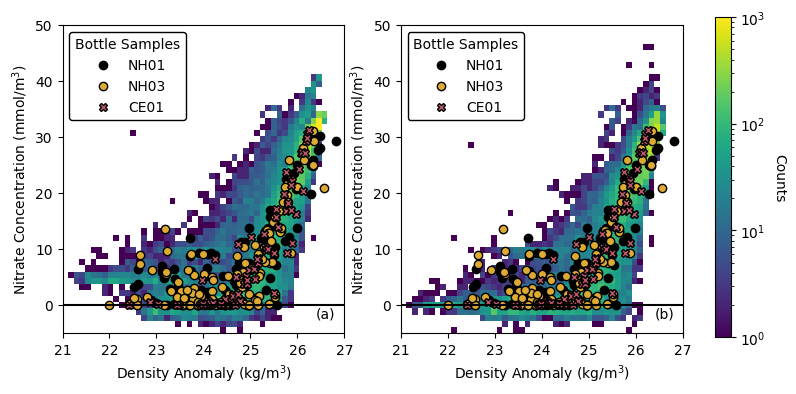

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# plot the nitrate data
sigma_theta = ds_bin.sigma_theta.values.flatten()
nitrate = ds_bin.salinity_corrected_nitrate.values.flatten()
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 50, 51)
mask = ((~np.isnan(sigma_theta)) & (~np.isnan(nitrate)))
hist, _, _ = np.histogram2d(sigma_theta[mask], nitrate[mask], bins=[x_bins, y_bins])
hist[hist == 0] = np.nan
pcm = axs[0].pcolormesh(x_bins, y_bins, hist.T, cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=1000))

# plot bottle sample data
sigma_theta = nh01_bottles.sigma_theta.values.flatten()
nitrate = nh01_bottles.nitrate.values.flatten()
axs[0].plot(sigma_theta, nitrate, 'o', label='NH01', mfc='k', mec='k')
sigma_theta = nh03_bottles.sigma_theta.values.flatten()
nitrate = nh03_bottles.nitrate.values.flatten()
axs[0].plot(sigma_theta, nitrate, 'o', label='NH03', mfc='#DDAA33', mec='k')
sigma_theta = ce01_bottles.sigma_theta.values.flatten()
nitrate = ce01_bottles.nitrate.values.flatten()
axs[0].plot(sigma_theta, nitrate, 'X', label='CE01', mfc='#BB5566', mec='k')
axs[0].legend(loc='upper left', title='Bottle Samples', facecolor='w', edgecolor='k', framealpha=1)
axs[0].set_xlabel('Density Anomaly ($\mathsf{kg/m^3}$)')
axs[0].set_ylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)')
axs[0].annotate('(a)', xy=(0.9, 0.05), xycoords='axes fraction')
axs[0].axhline(0, c='k')

# plot the nitrate data
sigma_theta = ds_bin_baseline_subtracted.sigma_theta.values.flatten()
nitrate = ds_bin_baseline_subtracted.salinity_corrected_nitrate.values.flatten()
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 50, 51)
mask = ((~np.isnan(sigma_theta)) & (~np.isnan(nitrate)))
hist, _, _ = np.histogram2d(sigma_theta[mask], nitrate[mask], bins=[x_bins, y_bins])
hist[hist == 0] = np.nan
pcm = axs[1].pcolormesh(x_bins, y_bins, hist.T, cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=1000))

# plot bottle sample data
sigma_theta = nh01_bottles.sigma_theta.values.flatten()
nitrate = nh01_bottles.nitrate.values.flatten()
axs[1].plot(sigma_theta, nitrate, 'o', label='NH01', mfc='k', mec='k')
sigma_theta = nh03_bottles.sigma_theta.values.flatten()
nitrate = nh03_bottles.nitrate.values.flatten()
axs[1].plot(sigma_theta, nitrate, 'o', label='NH03', mfc='#DDAA33', mec='k')
sigma_theta = ce01_bottles.sigma_theta.values.flatten()
nitrate = ce01_bottles.nitrate.values.flatten()
axs[1].plot(sigma_theta, nitrate, 'X', label='CE01', mfc='#BB5566', mec='k')
axs[1].legend(loc='upper left', title='Bottle Samples', facecolor='w', edgecolor='k', framealpha=1)
axs[1].set_xlabel('Density Anomaly ($\mathsf{kg/m^3}$)')
axs[1].set_ylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)')
axs[1].annotate('(b)', xy=(0.9, 0.05), xycoords='axes fraction')
axs[1].axhline(0, c='k')

cax = fig.add_axes([0.94, 0.1, 0.02, 0.8])
cbar = plt.colorbar(pcm, cax)
cbar.set_label('Counts', rotation=270, labelpad=15)

plt.savefig('./CE01ISSP_nitrate_density.png', dpi=600)

And we are all done! The final plot looks much better than where we started. This final step is to save the datasets locally, which I leave up to you (`ds_bin.to_netcdf('file.nc')` does the trick). Alternatively, you can use my [command line tool](https://github.com/andrew-s28/ooi-profiler-nitrate-retriever), which automates this entire notebook into one easy commanad. Best of luck with your nitrate investigations from here!

## Site CE02SHSP

The above process is now repeated for the nitrate data from the midshelf profiler, site CE02SHSP. The steps are identical except where noted, and the details are left out of things that have already been shown for site CE01ISSP.

### Accessing the Dataset

Note the site name has been changed in this step

In [16]:
# download all datasets
ds = _get_datasets('CE02SHSP', '2010-01-01', pd.Timestamp.now().strftime('%Y-%m-%d'))
# save original data for comparison
ds_orig = ds.copy()

Next we do some variable renaming and calculate the absolute salinity, conservative temperature, and potential density. We also save the metadata to include with the final dataset, since the next steps will remove it.

In [17]:
for i, d in enumerate(ds):
    # compute derived variables
    ds[i] = _comput_tsrho(d)
    # save metadata to include in final dataset
    global_attrs, var_attrs = _get_attrs(ds[i])

### Performing Quality Control

QCing datasets:   0%|          | 0/32 [00:00<?, ?it/s]

QCing datasets: 100%|██████████| 32/32 [00:13<00:00,  2.43it/s]


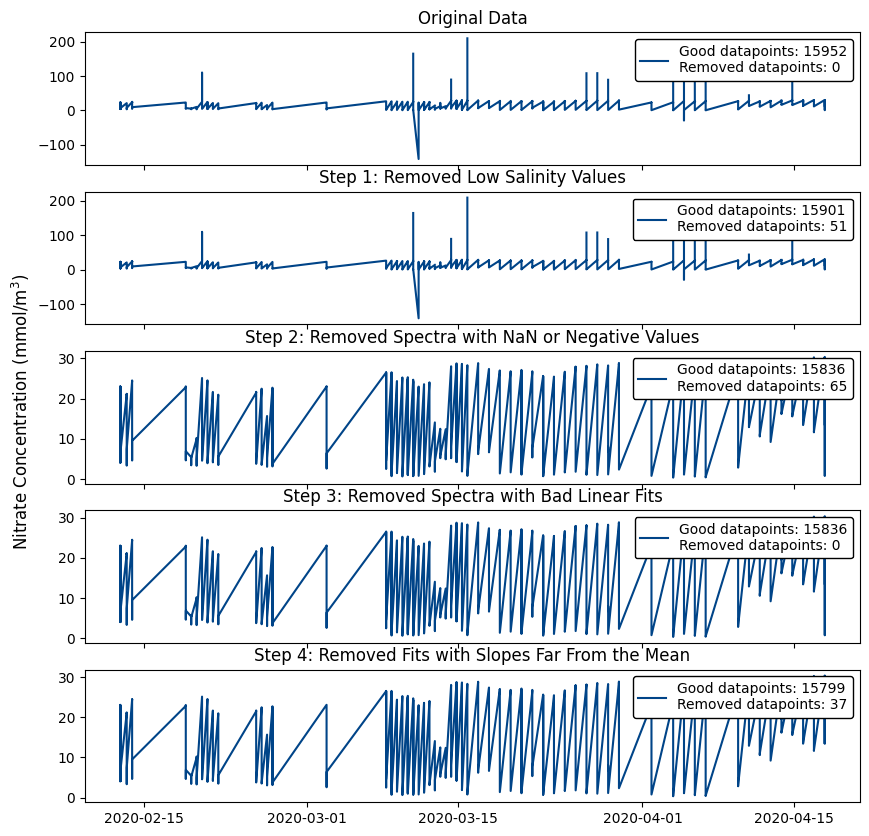

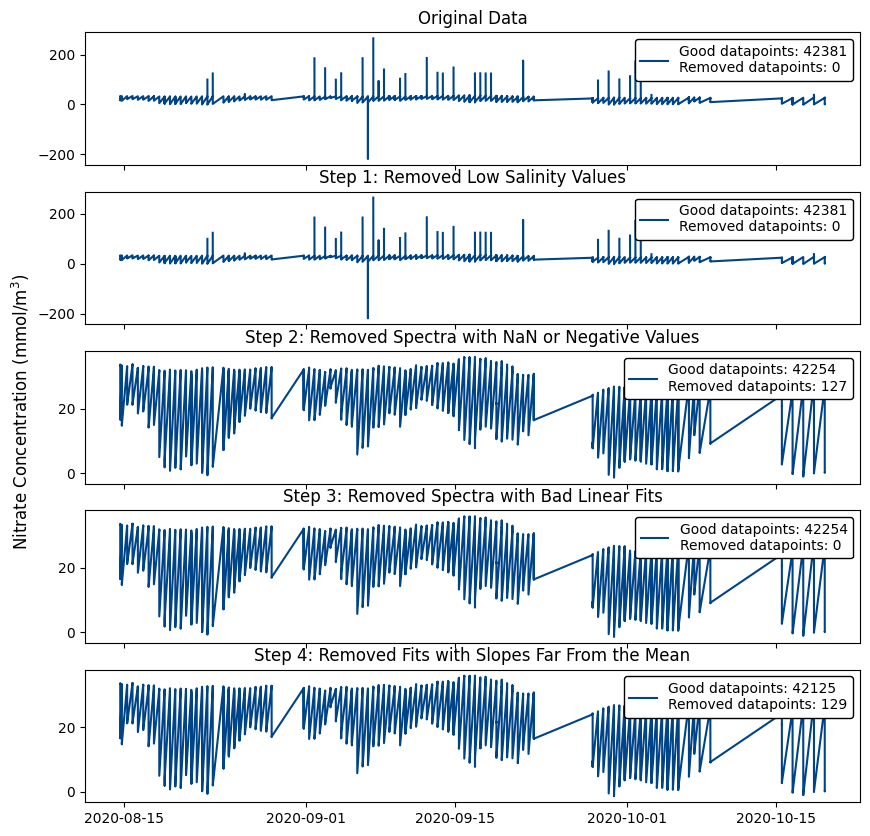

In [18]:
# QC nitrate data and remove short datasets
deployments, total_data, good_data, step_1, step_2, step_3, step_4 = [], [], [], [], [], [], []
for i, d in enumerate(tq(ds, desc='QCing datasets')):
    deployments.append(np.unique(d.deployment)[0])
    total_data.append(d.time.size)  
    out = _nutnr_qc_wrapper(d)
    if deployments[-1] in [17, 18]:
        plt.savefig(f'./CE02SHSP_dep{deployments[-1]}_qc.png', dpi=600)
    ds[i] = out[0]
    good_data.append(out[1])
    step_1.append(out[2])
    step_2.append(out[3])
    step_3.append(out[4])
    step_4.append(out[5])

# save QC results to DataFrame
qc_results = pd.DataFrame(
    {
        'deployment': deployments,
        'total_data': total_data,
        'good_data': good_data,
        'bad_data': np.subtract(np.array(total_data), np.array(good_data)),
        'bad_salinity': step_1,
        'bad_values': step_2,
        'bad_fit': step_3,
        'bad_slope': step_4,
    },
    columns=['deployment', 'total_data', 'good_data', 'bad_data', 'bad_salinity', 'bad_values', 'bad_fit', 'bad_slope'],
)

We can see the majority of really bad data is removed simply by removing spectra that contain NaN or negative values (step 2). The other steps just handle a few stray outliers. Now that the QC process is done (and notice that we have already saved the output to the same variable `ds`), we can proceed to the binning and saving. First, we remove datasets which have no data after the QC process. We also save the unbinned but QCed dataset for later use.

In [19]:
# remove datasets with no data after QC
for i, d in enumerate(ds):
    if d.time.size == 0:
        ds.pop(i)
        print(f"Deployment {ds_orig[i].deployment.values[0]} removed due to lack of data after QC.")
ds_qced = ds.copy()

Deployment 2 removed due to lack of data after QC.


### Binning

Now we get the highest and lowest depth bins from the entire dataset and construct some bin centers and edges using a 1 m bin height.

In [20]:
# find minimum and maximum depth bins over all nitrate data
sur = np.min(xr.concat(ds, dim='time')['depth'])
bot = np.max(xr.concat(ds, dim='time')['depth'])

# setup depth/pressure bins
step = 1
sur = np.floor(sur)
bot = np.ceil(bot)
# pressure_grid is centers of bins
pressure_grid = np.arange(sur+step/2, bot+step, step)
# pressure_bins is edges of bins
pressure_bins = np.nan*np.empty(len(pressure_grid)+1)
pressure_bins[0] = pressure_grid[0] - step/2
pressure_bins[-1] = pressure_grid[-1] + step/2
for i in range(len(pressure_bins)-2):
    pressure_bins[i+1] = np.average([pressure_grid[i], pressure_grid[i+1]])

Finally, we bin them using an optimized binning algorithm, `flox.xarray_reduce`. This significantly speeds up the binning operation, but it still can take five to ten minutes. Run this next cell and go grab yourself some coffee while you wait!

In [21]:
# bin datasets into new list
deployments = []
times = []
for d in tq(ds, desc='Splitting and binning profiles'):
    deployments.append(split_profiles(d))
    # print(deployments[-1])
    profiles = []
    profile_times = []
    for profile in deployments[-1]:
        profile_binned = profiler_binning(profile, pressure_bins, offset=0.5)
        profiles.append(profile_binned.mean(dim='time'))
        profile_times.append(profile_binned.time.mean().values)
    deployments[-1] = profiles
    times.append(xr.DataArray(profile_times, dims='time'))
deployments = [xr.concat(profiles, profile_times) for profiles, profile_times in zip(deployments, times)]
# remove datasets with less than 10 profiles data
for i, d in enumerate(deployments):
    if d.time.size < 10:
        deployments.pop(i)
        print(f"Deployment {d.deployment.mean().values} removed due to having less than 10 profiles after QC and binning.")

# concatenate binned datasets
ds_bin = xr.concat(deployments, dim='time')
ds_bin = ds_bin.drop_duplicates('time', keep='first')
ds_bin = ds_bin.where(~np.isinf(ds_bin.salinity_corrected_nitrate))
ds_bin = _assign_attrs(ds_bin, global_attrs, var_attrs)

Splitting and binning profiles: 100%|██████████| 31/31 [02:20<00:00,  4.53s/it]


Deployment 26.0 removed due to having less than 10 profiles after QC and binning.
Deployment 29.0 removed due to having less than 10 profiles after QC and binning.


### Reviewing the Results

Before we go any further, let's take a look at the QC results.

In [22]:
qc_results

,deployment,total_data,good_data,bad_data,bad_salinity,bad_values,bad_fit,bad_slope
0,1,1835,1820,15,2,5,0,8
1,2,1674,0,1674,0,1674,0,0
2,3,2266,2223,43,0,32,0,11
3,4,1221,1202,19,0,17,0,2
4,5,593,587,6,0,3,0,3
5,6,227,227,0,0,0,0,0
6,7,2693,2645,48,0,45,0,3
7,8,1302,1286,16,0,10,0,6
8,9,747,743,4,0,0,0,4
9,10,413,411,2,0,0,0,2


Again, the results seem good, with a few percent of data being thrown out from each deployment. Like at CE01ISSP, there is one exception to that, this time deployment 2 (row 1), which had the entire 1,674 datapoints removed in the QC process. Of course, this dataset is discarded.

In [23]:
qc_results[(qc_results.deployment != 2) & (qc_results.deployment != 26) & (qc_results.deployment != 29)].sum(axis=0)

deployment         471
total_data      318398
good_data       316232
bad_data          2166
bad_salinity       207
bad_values        1106
bad_fit              0
bad_slope          853
dtype: int64

We can now get rid of the unused variables in the dataset.

In [24]:
ds_bin = _drop_unused_vars(ds_bin)

### Validating with Bottle Samples

 This time, we only have OOI bottle samples to compare too. Note that the density-nitrate relationship has not really changed between the sites, though.

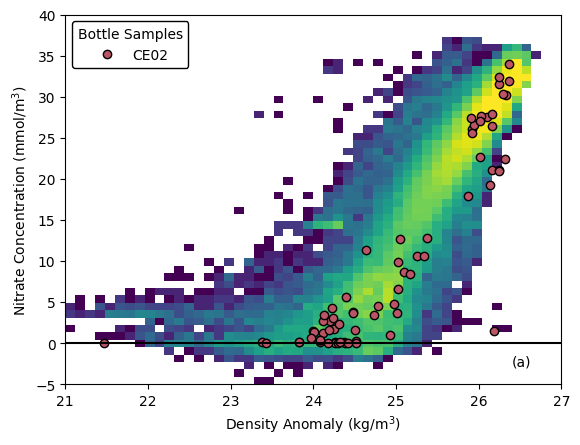

In [25]:
ce02_bottles = xr.open_dataset('bottle_samples\ce02_nitrate_bottles.nc')

# plot the nitrate data
sigma_theta = ds_bin.sigma_theta.values.flatten()
nitrate = ds_bin.salinity_corrected_nitrate.values.flatten()
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 40, 51)
mask = ((~np.isnan(sigma_theta)) & (~np.isnan(nitrate)))
hist, _, _ = np.histogram2d(sigma_theta[mask], nitrate[mask], bins=[x_bins, y_bins])
hist[hist == 0] = np.nan
pcm = plt.pcolormesh(x_bins, y_bins, hist.T, cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=1000))

# plot bottle sample data
sigma_theta = ce02_bottles.sigma_theta.values.flatten()
nitrate = ce02_bottles.nitrate.values.flatten()
plt.plot(sigma_theta, nitrate, 'o', label='CE02', mfc='#BB5566', mec='k')
plt.legend(loc='upper left', title='Bottle Samples', facecolor='w', edgecolor='k', framealpha=1)
plt.xlabel('Density Anomaly ($\mathsf{kg/m^3}$)')
plt.ylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)')
plt.annotate('(a)', xy=(0.9, 0.05), xycoords='axes fraction')
plt.axhline(0, c='k')

We still have some offsets from the expected graph as at CE01ISSP. Fortunately, the process of baseline shifting the midshelf data is made easier because it can be safely assumed that the median value of the surface nitrate will be zero for any given deployment ([Pavelsky, et. al., 2023](https://repository.oceanbestpractices.org/handle/11329/2112.2)). So instead, we just find the median value of the surface bin and subtract that from the nitrate concentrations.

In [26]:
# force surface bin to have zero median in each deployment
for i, d in enumerate(deployments):
    baseline = d.where(d.depth < 2).salinity_corrected_nitrate.median().values
    deployments[i]['salinity_corrected_nitrate'] = d['salinity_corrected_nitrate'] - baseline

ds_bin_baseline_subtracted = xr.concat(deployments, dim='time')
ds_bin_baseline_subtracted = _assign_attrs(ds_bin_baseline_subtracted, global_attrs, var_attrs)
ds_bin_baseline_subtracted = _drop_unused_vars(ds_bin_baseline_subtracted)

### Wrapping Up

Taking a look at the nitrate-density graph one more time:

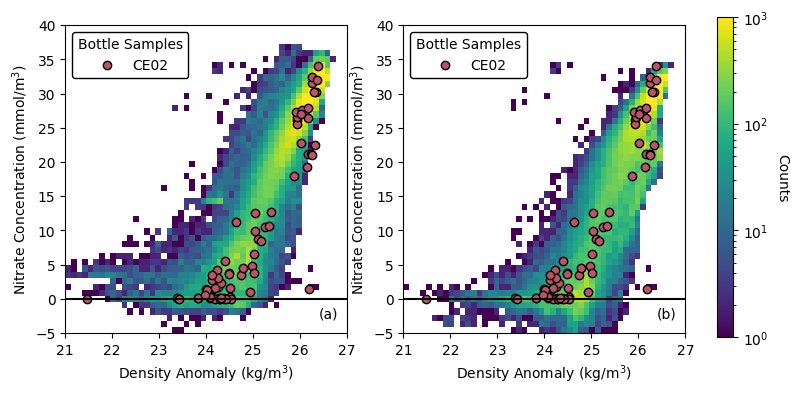

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

# plot the nitrate data
sigma_theta = ds_bin.sigma_theta.values.flatten()
nitrate = ds_bin.salinity_corrected_nitrate.values.flatten()
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 40, 51)
mask = ((~np.isnan(sigma_theta)) & (~np.isnan(nitrate)))
hist, _, _ = np.histogram2d(sigma_theta[mask], nitrate[mask], bins=[x_bins, y_bins])
hist[hist == 0] = np.nan
pcm = axs[0].pcolormesh(x_bins, y_bins, hist.T, cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=1000))

# plot bottle sample data
sigma_theta = ce02_bottles.sigma_theta.values.flatten()
nitrate = ce02_bottles.nitrate.values.flatten()
axs[0].plot(sigma_theta, nitrate, 'o', label='CE02', mfc='#BB5566', mec='k')
axs[0].legend(loc='upper left', title='Bottle Samples', facecolor='w', edgecolor='k', framealpha=1)
axs[0].set_xlabel('Density Anomaly ($\mathsf{kg/m^3}$)')
axs[0].set_ylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)')
axs[0].annotate('(a)', xy=(0.9, 0.05), xycoords='axes fraction')
axs[0].axhline(0, c='k')

# plot the nitrate data
sigma_theta = ds_bin_baseline_subtracted.sigma_theta.values.flatten()
nitrate = ds_bin_baseline_subtracted.salinity_corrected_nitrate.values.flatten()
x_bins = np.linspace(21, 27, 51)
y_bins = np.linspace(-5, 40, 51)
mask = ((~np.isnan(sigma_theta)) & (~np.isnan(nitrate)))
hist, _, _ = np.histogram2d(sigma_theta[mask], nitrate[mask], bins=[x_bins, y_bins])
hist[hist == 0] = np.nan
pcm = axs[1].pcolormesh(x_bins, y_bins, hist.T, cmap='viridis', norm=mcolors.LogNorm(vmin=1, vmax=1000))

# plot bottle sample data
sigma_theta = ce02_bottles.sigma_theta.values.flatten()
nitrate = ce02_bottles.nitrate.values.flatten()
axs[1].plot(sigma_theta, nitrate, 'o', label='CE02', mfc='#BB5566', mec='k')
axs[1].legend(loc='upper left', title='Bottle Samples', facecolor='w', edgecolor='k', framealpha=1)
axs[1].set_xlabel('Density Anomaly ($\mathsf{kg/m^3}$)')
axs[1].set_ylabel('Nitrate Concentration ($\mathsf{mmol/m^3}$)')
axs[1].annotate('(b)', xy=(0.9, 0.05), xycoords='axes fraction')
axs[1].axhline(0, c='k')

cax = fig.add_axes([0.94, 0.1, 0.02, 0.8])
cbar = plt.colorbar(pcm, cax)
cbar.set_label('Counts', rotation=270, labelpad=15)
# plt.tight_layout()
plt.savefig('./CE02SHSP_nitrate_density.png', dpi=600, bbox_inches = "tight")

The median baseline shift worked well, and the CE02SHSP profiler nitrate dataset is now ready to go also.

This final step is to save the datasets locally. Alternatively, you can use my [command line tool](https://github.com/andrew-s28/ooi-profiler-nitrate-retriever), which automates this entire notebook into one easy commanad. Best of luck with your nitrate investigations from here!